## Analysis

Imports

In [1]:
import os
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax

from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
from functools import partial

import math
import csv
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy
from util import create_gratings
from SSN_classes_jax_jit import SSN2DTopoV1_AMPAGABA_ONOFF

Parameters

In [2]:
######################### STIMULI PARAMETERS ########################
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 0, jitter_val = 5)
stimuli_pars.update(general_pars)



######################### NETWORK PARAMETERS ########################
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    A=None
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)
    
    
class conn_pars():
    PERIODIC = False
    p_local = [0.4, 0.7]
    sigma_oris = 1000
    
class filter_pars():
    sigma_g = numpy.array(0.5)
    conv_factor = numpy.array(2)
    k = numpy.array(1.0471975511965976)
    edge_deg = numpy.array( 3.2)
    degree_per_pixel = numpy.array(0.05)
    


#########################OPTIMIZATION PARAMETERS ########################

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09



make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

print(J_2x2)

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)

#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

#key, _ = random.split(key)
#w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)
#w_sig = np.zeros((N_neurons))
b_sig = 0.0

#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)

class conv_pars:
    dt = 1
    xtol = 1e-05
    Tmax = 1000
    verbose = False
    silent = True

class loss_pars:
    lambda_1 = 1
    lambda_2 = 1
    lambda_w = 1
    lambda_b = 1
    

ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
ssn_pars.A=ssn.A

[[ 4.4413204 -1.6582118]
 [ 5.0289063 -1.2416493]]


In [3]:
def plot_losses(training_losses, validation_losses, epochs_to_save):
    plt.plot(training_losses.T, label = ['Binary cross entropy', 'Avg_dx', 'R_max', 'w', 'b', 'Training total'] )
    plt.plot(epochs_to_save, validation_losses, label='Validation')
    plt.legend()
    plt.title('Training losses')
    plt.show()
    
    
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data



def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x, epsilon = 0.001):
    
    '''
    Introduction of epsilon stops asymptote from reaching 1 (avoids NaN)
    '''
   
    sig = 1/(1+np.exp(x))
    
    return (1 - 2*epsilon)*sig + epsilon


def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

#@partial(jax.jit, static_argnums=(1, 2, 3, 5, 6 , 7 , 8 ))#, device = jax.devices()[1]) + ADD 9 FOR TRAINING
def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    J_2x2, s_2x2 = exponentiate(opt_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find the fixed point 
    x_ref, r_max_ref, avg_dx_ref = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    x_target, r_max_target, avg_dx_target = obtain_fixed_point(ssn, SSN_input_target, conv_pars)
    
    #Add additional noise before sigmoid layer
    #if sig_noise:
    delta_x = x_ref.ravel() - x_target.ravel() 
    external_noise = sig_noise*numpy.random.normal(size=((x_target.ravel()).shape))
    delta_x = delta_x + external_noise
    #else:
        #delta_x = x_ref.ravel() - x_target.ravel() 
    
    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (delta_x)) + opt_pars['b_sig'])

    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = loss_pars.lambda_1*(avg_dx_ref + avg_dx_target)/2
    loss_r_max =  loss_pars.lambda_2*(r_max_ref + r_max_target)/2
    loss_w = loss_pars.lambda_w*(np.linalg.norm(opt_pars['w_sig'])**2)
    loss_b = loss_pars.lambda_b*(opt_pars['b_sig']**2)
    
    #Combine all losses
    loss = loss_binary +  loss_avg_dx + loss_r_max  + loss_w + loss_b
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    pred_label = np.round(x) 
    
    #Calculate predicted label using Bernoulli distribution
    if bernoulli==True:
        key_int = numpy.random.randint(low = 0, high =  10000)
        key = random.PRNGKey(key_int)
        pred_label_b = np.sum(jax.random.bernoulli(key, p=x, shape=None))
        pred_label = [pred_label, pred_label_b]
    
    return loss, all_losses, pred_label


def obtain_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100):
    
    r_init = np.zeros(ssn_input.shape[0])
    
    dt = conv_pars.dt
    xtol = conv_pars.xtol
    Tmax = conv_pars.Tmax
    verbose = conv_pars.verbose
    silent = conv_pars.silent
    
    #Find fixed point  
   
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, dt=dt, xtol=xtol, Tmax=Tmax, verbose = verbose, silent=silent)
    avg_dx = np.maximum(0, (avg_dx -1))
    
    #Apply bounding box to data
    x_box = ssn.apply_bounding_box(fp, size=3.2)
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return x_box, r_max, avg_dx




def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli, sig_noise):
    
    eval_vmap = vmap(model, in_axes = ({'b_sig': None,  'c_E':None, 'c_I': None,  'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, None,  {'ref':0, 'target':0, 'label':0}, None, None, None, None, None) )
    losses, _, pred_labels = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars, conv_pars, loss_pars, bernoulli, sig_noise) 

    #Find accuracy based on predicted labels
    true_accuracy = np.sum(test_data['label'] == pred_labels[0])/len(test_data['label']) 
    ber_accuracy = np.sum(test_data['label'] == pred_labels[1])/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, true_accuracy, ber_accuracy




## Post training analysis

Value interpolation

In [4]:
def assemble_pars(all_pars, matrix = True):
    '''
    Take parameters from csv file and 
    
    '''
    pre_train = np.asarray(all_pars.iloc[0].tolist())
    post_train =  np.asarray(all_pars.iloc[-1].tolist())

    if matrix == True:
        matrix_pars = lambda Jee, Jei, Jie, Jii: np.array([[Jee, Jei], [Jie,  Jii]])

        pre_train = matrix_pars(*pre_train)
        post_train = matrix_pars(*post_train)
    
    
    return pre_train, post_train




def plot_acc_vs_param(to_plot, type_param = None, param = None):
    '''
    Input:
        Matrix with shape (N+1, length of lambda) - each row corresponds to a different value of lambda, params at that value and 
        the accuracy obtained
    Output:
        Plot of the desired param against the accuracy 
    '''
    
    plt.plot(to_plot[:, param].T, to_plot[:, 0].T)
    plt.ylabel('Accuracy')
    
    if type_param == 'J':
        if param ==1:
            plt.xlabel('J_EE')
        if param ==2:
            plt.xlabel('J_EI')
        if param ==3:
            plt.xlabel('J_IE')
        if param ==4:
            plt.xlabel('J_II')
            
    if type_param == 's':
        if param ==1:
            plt.xlabel('s_EE')
        if param ==2:
            plt.xlabel('s_EI')
        if param ==3:
            plt.xlabel('s_IE')
        if param ==4:
            plt.xlabel('s_II')
    
    if type_param == 'c':
        if param ==1:
            plt.xlabel('c_E')
        if param ==2:
            plt.xlabel('c_I')

        
        
    plt.show()


    
def case_1(pre_J, post_J, opt_pars, test_data, type_param =None):
    '''
    Interpolate all parameters and evaluate accuracy at each value.
    Input:
        list of pre and post values of J
        opt_pars for other optimisation parameters
        test_data
    Output:
        Matrix with shape (N+1, length of lambda) - each row corresponds to a different value of lambda, params at that value and 
        the accuracy obtained   
    '''
    
    Js = []
    accuracy = []
    lambdas = np.linspace(0,1,10)
    for lamb in lambdas:
        new_param = (1-lamb)*pre_param + lamb * post_param
        
        #Change only selected parameter
        if type_param =='J':
            opt_pars['logJ_2x2'] = np.log(new_param*signs)
        if type_param =='s':
            opt_pars['logs_2x2'] = np.log(new_param)
        if type_param =='c':
            opt_pars['c_E'] = new_param[0]
            opt_pars['c_I'] = new_param[1]
            print(opt_pars['c_E']) 
        val_loss, true_acc, ber_acc= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2.5)
        print('lambda ', lamb, ', accuracy', true_acc)
        Js.append([J for J in J_2x2.ravel()])
        accuracy.append(true_acc)

    return np.column_stack([np.vstack(accuracy), np.vstack(Js)])
    

def case_2(pre_param, post_param, opt_pars, test_data, type_param = None, index=None):
    '''
    Interpolate a single trained parameter and evaluate accuracy at each value. Produce plot of param against accuracy
    Input:
        list of pre and post values of J
        opt_pars for other optimisation parameters
        test_data
        desired param from the matrix (0,0) - J_EE ¦ (0,1) - J_EI, ¦ (1,0) - J_IE ¦ (1,1) - J_II
    Output:
        Matrix with shape (N+1, length of lambda) - each row corresponds to a different value of lambda, params at that value and 
        the accuracy obtained
        Plot of the changing parameter against accuracy
        
    '''
    values = []
    accuracy = []
    lambdas = np.linspace(0,1,10)
    parameter_matrix = np.asarray([[1,2],[3,4]]) 
    plot_param = parameter_matrix[index]
    
    #Create evenly spaced parameters to interpolate
    lambdas = np.linspace(0,1,10)
    
    for lamb in lambdas:
        
        #Update values of J according to interpolation
        new_param = np.copy(post_param)
        new_param = new_param.at[index].set((1-lamb)*pre_param[index] + lamb*post_param[index])
        
        #Take logs before passing through model
        if type_param =='J':
            opt_pars['logJ_2x2'] = np.log(new_param*signs)
        if type_param =='s':
            opt_pars['logs_2x2'] = np.log(new_param)
        if type_param =='c':
            opt_pars['c_E'] = new_param[0]
            opt_pars['c_I'] = new_param[1]
            plot_param = int(index+1)

        
        #Evaluate accuracy
        val_loss, true_acc, ber_acc= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2.5)
        print('lambda ', lamb, ', accuracy', true_acc)
        
        #Store values of J and accuracy
        values.append([param for param in new_param.ravel()])
        accuracy.append(true_acc)

    to_plot = np.column_stack([np.vstack(accuracy), np.vstack(values)])
    
    #Plot parameters
    plot_acc_vs_param(to_plot, type_param = type_param, param= plot_param)
    
    return to_plot





In [5]:
opt_pars['w_sig'] = np.asarray([ 0.12605566,  0.1273912,   0.18054508, -0.27392012, -0.01211993, -0.03041697,
  0.0826202,   0.41804752,  0.1202573,  -0.03632501,  0.18295377,  0.30918923,
 -0.1940052,   0.20544377, -0.2499748,  -0.08071887,  0.19058336,  0.03633068,
 -0.02569352, -0.16947141, -0.2595211,  -0.04320447,  0.13482924, -0.05088398,
  0.1140677 ])
opt_pars['b_sig'] = -0.06537655

In [6]:
results_file = '/mnt/d/ABG_Projects_Backup/ssn_modelling/ssn-simulator/results/jitted_function/fixed_w_ssn_train70.csv'
results = pd.read_csv(results_file, header = 0)
all_J = results[['J_EE', 'J_EI', 'J_IE', 'J_II' ]]
all_s = results[['s_EE', 's_EI', 's_IE', 's_II' ]]
all_c = results[['c_E', 'c_I']]

pre_c, post_c = assemble_pars(all_c, matrix=False)
pre_s, post_s = assemble_pars(all_s)
pre_J, post_J = assemble_pars(all_J)

#Initialise opt_pars as post training values
opt_pars['logs_2x2'] = np.log(post_s)
opt_pars['c_E'] = post_c[0]
opt_pars['c_I'] = post_c[1]
opt_pars['logJ_2x2'] = np.log(post_J*signs)

In [7]:
stimuli_pars['jitter_val'] =0

CASE 1

In [8]:
test_data = create_data(stimuli_pars, number = 200, offset = 2, ref_ori = 55)

In [11]:
np.sum(test_data['ref'][0] - test_data['ref'][1])

DeviceArray(0., dtype=float16)

In [10]:
stimuli_pars

{'outer_radius': 3,
 'inner_radius': 2.5,
 'grating_contrast': 0.8,
 'std': 0,
 'jitter_val': 0,
 'k': 1.0471975511965976,
 'edge_deg': 3.2,
 'degree_per_pixel': 0.05}

50


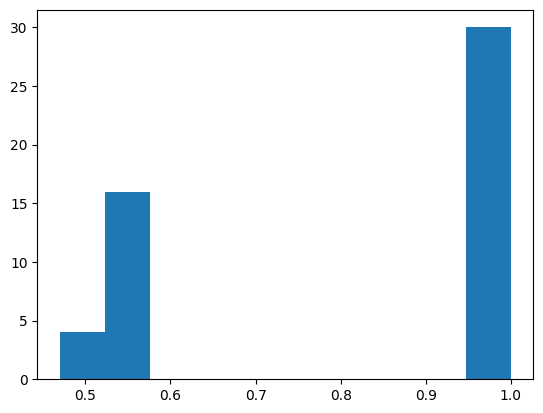

0.23661818


In [13]:
list_accs = []
test_data = create_data(stimuli_pars, number = 100, offset = 2, ref_ori = 55)
for i in range(0,50):
    
    _, true_acc, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, loss_pars, bernoulli=True, sig_noise=2.5)
    list_accs.append(true_acc)

list_accs = np.asarray(list_accs)
print(len(list_accs))
plt.hist(list_accs)
plt.show()

print(np.std(list_accs))

In [26]:
case_1_matrix = case_1(pre_J, post_J, opt_pars, test_data)

lambda  0.0 , accuracy 0.44
lambda  0.11111111 , accuracy 0.525
lambda  0.22222222 , accuracy 0.475
lambda  0.33333334 , accuracy 0.525
lambda  0.44444445 , accuracy 0.525
lambda  0.5555556 , accuracy 0.525
lambda  0.6666667 , accuracy 0.475
lambda  0.7777778 , accuracy 0.475
lambda  0.8888889 , accuracy 0.89
lambda  1.0 , accuracy 0.855


In [ ]:
ssn?

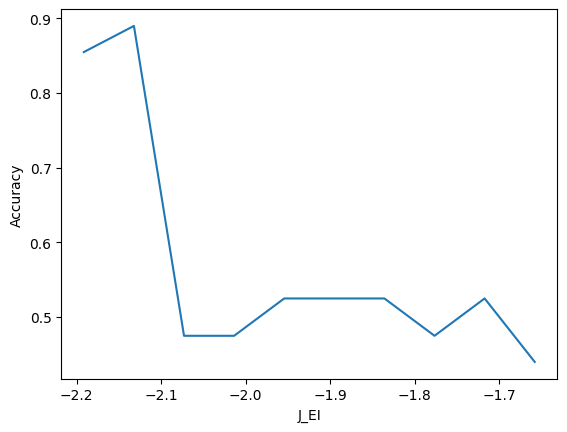

In [27]:
plot_acc_vs_param(case_1_matrix, param =2)

CASE 2

lambda  0.0 , accuracy 0.0
lambda  0.11111111 , accuracy 0.0
lambda  0.22222222 , accuracy 0.0
lambda  0.33333334 , accuracy 0.0
lambda  0.44444445 , accuracy 0.0
lambda  0.5555556 , accuracy 0.0
lambda  0.6666667 , accuracy 0.0
lambda  0.7777778 , accuracy 1.0
lambda  0.8888889 , accuracy 0.62
lambda  1.0 , accuracy 0.975


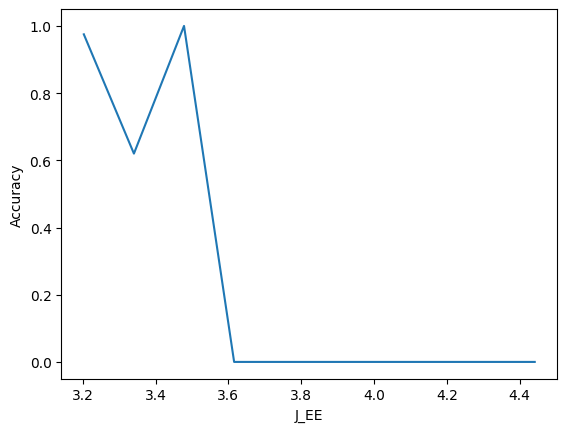

DeviceArray([[ 0.       ,  4.4413204, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  4.3037496, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  4.1661787, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  4.0286074, -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  3.891037 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  3.753466 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.       ,  3.6158948, -2.1914783,  4.076988 , -2.0541077],
             [ 1.       ,  3.478324 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.62     ,  3.340753 , -2.1914783,  4.076988 , -2.0541077],
             [ 0.975    ,  3.2031822, -2.1914783,  4.076988 , -2.0541077]],            dtype=float32)

In [40]:
case_2(pre_J, post_J, opt_pars, test_data, type_param = 'J', index = (0,0))

lambda  0.0 , accuracy 0.0
lambda  0.11111111 , accuracy 0.0
lambda  0.22222222 , accuracy 0.0
lambda  0.33333334 , accuracy 0.0
lambda  0.44444445 , accuracy 0.0
lambda  0.5555556 , accuracy 0.0
lambda  0.6666667 , accuracy 0.98
lambda  0.7777778 , accuracy 1.0
lambda  0.8888889 , accuracy 1.0
lambda  1.0 , accuracy 1.0


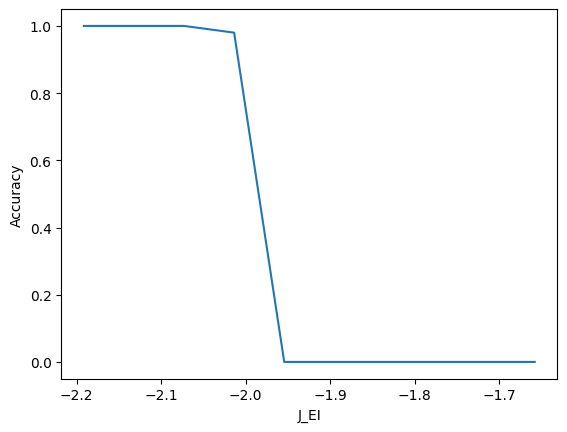

DeviceArray([[ 0.       ,  3.2031822, -1.6582118,  4.076988 , -2.0541077],
             [ 0.       ,  3.2031822, -1.7174637,  4.076988 , -2.0541077],
             [ 0.       ,  3.2031822, -1.7767155,  4.076988 , -2.0541077],
             [ 0.       ,  3.2031822, -1.8359673,  4.076988 , -2.0541077],
             [ 0.       ,  3.2031822, -1.8952191,  4.076988 , -2.0541077],
             [ 0.       ,  3.2031822, -1.9544709,  4.076988 , -2.0541077],
             [ 0.98     ,  3.2031822, -2.013723 ,  4.076988 , -2.0541077],
             [ 1.       ,  3.2031822, -2.0729747,  4.076988 , -2.0541077],
             [ 1.       ,  3.2031822, -2.1322265,  4.076988 , -2.0541077],
             [ 1.       ,  3.2031822, -2.1914783,  4.076988 , -2.0541077]],            dtype=float32)

In [42]:
case_2(pre_J, post_J, opt_pars, test_data, type_param = 'J', index = (0,1))

lambda  0.0 , accuracy 0.525
lambda  0.11111111 , accuracy 1.0
lambda  0.22222222 , accuracy 0.68
lambda  0.33333334 , accuracy 0.475
lambda  0.44444445 , accuracy 0.68
lambda  0.5555556 , accuracy 0.475
lambda  0.6666667 , accuracy 0.9
lambda  0.7777778 , accuracy 0.525
lambda  0.8888889 , accuracy 0.705
lambda  1.0 , accuracy 0.93


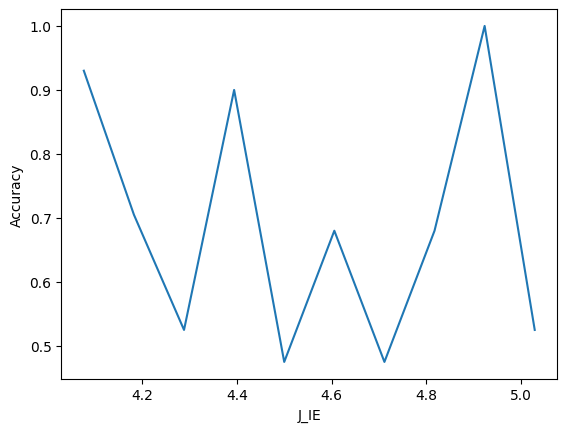

DeviceArray([[ 0.525    ,  3.2031822, -2.1914783,  5.0289063, -2.0541077],
             [ 1.       ,  3.2031822, -2.1914783,  4.9231377, -2.0541077],
             [ 0.68     ,  3.2031822, -2.1914783,  4.817369 , -2.0541077],
             [ 0.475    ,  3.2031822, -2.1914783,  4.7116003, -2.0541077],
             [ 0.68     ,  3.2031822, -2.1914783,  4.605832 , -2.0541077],
             [ 0.475    ,  3.2031822, -2.1914783,  4.500063 , -2.0541077],
             [ 0.9      ,  3.2031822, -2.1914783,  4.3942943, -2.0541077],
             [ 0.525    ,  3.2031822, -2.1914783,  4.2885256, -2.0541077],
             [ 0.705    ,  3.2031822, -2.1914783,  4.182757 , -2.0541077],
             [ 0.93     ,  3.2031822, -2.1914783,  4.076988 , -2.0541077]],            dtype=float32)

In [43]:
case_2(pre_J, post_J, opt_pars, test_data, type_param = 'J', index = (1,0))

lambda  0.0 , accuracy 0.47
lambda  0.11111111 , accuracy 0.525
lambda  0.22222222 , accuracy 0.525
lambda  0.33333334 , accuracy 0.525
lambda  0.44444445 , accuracy 0.575
lambda  0.5555556 , accuracy 0.525
lambda  0.6666667 , accuracy 0.475
lambda  0.7777778 , accuracy 1.0
lambda  0.8888889 , accuracy 0.545
lambda  1.0 , accuracy 1.0


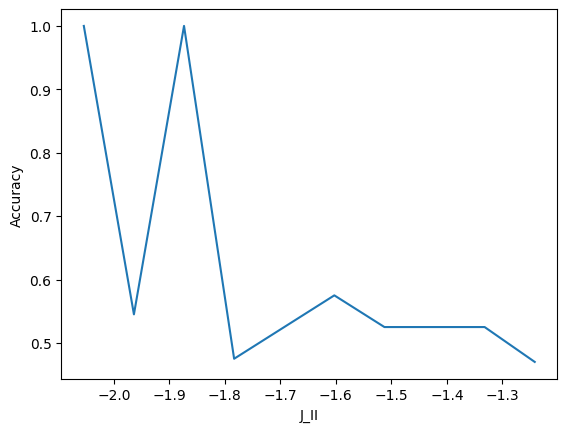

DeviceArray([[ 0.47     ,  3.2031822, -2.1914783,  4.076988 , -1.2416493],
             [ 0.525    ,  3.2031822, -2.1914783,  4.076988 , -1.3319224],
             [ 0.525    ,  3.2031822, -2.1914783,  4.076988 , -1.4221956],
             [ 0.525    ,  3.2031822, -2.1914783,  4.076988 , -1.5124687],
             [ 0.575    ,  3.2031822, -2.1914783,  4.076988 , -1.602742 ],
             [ 0.525    ,  3.2031822, -2.1914783,  4.076988 , -1.6930151],
             [ 0.475    ,  3.2031822, -2.1914783,  4.076988 , -1.7832882],
             [ 1.       ,  3.2031822, -2.1914783,  4.076988 , -1.8735614],
             [ 0.545    ,  3.2031822, -2.1914783,  4.076988 , -1.9638345],
             [ 1.       ,  3.2031822, -2.1914783,  4.076988 , -2.0541077]],            dtype=float32)

In [44]:
case_2(pre_J, post_J, opt_pars, test_data, type_param = 'J', index = (1,1))

## Surround suppression

In [16]:
radii = np.linspace(0, 3.2, 10)
stimulis = []
for radius in radii:
        stimuli_pars['outer_radius'] = radius
        stimuli_pars['inner_radius'] = radius
        
        test_data = create_data(stimuli_pars, number = 1, offset = 2, ref_ori = 55)
        stimulis.append(test_data['ref'][0])

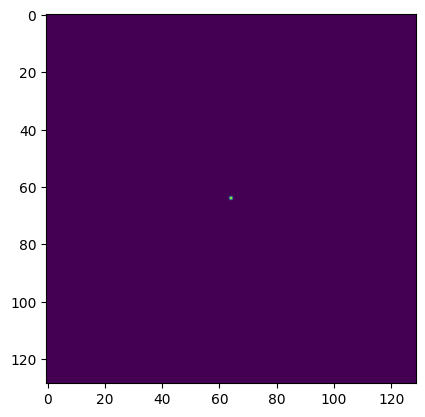

In [47]:
plt.imshow(stimulis[0].reshape(129,129))

In [19]:
def surround_suppresion(ssn_pars, grid_pars, conn_pars, filter_pars, stimulis, J_2x2, s_2x2, radii, constant_vector):
    
    all_responses = []
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=pre_J, s_2x2=pre_J)
    centre_ori = 55 #ssn.ori_map[5,5]
    print(centre_ori) #create stimuli in the function just input radii)
    for stimuli in stimulis:

        output_ref=np.matmul(ssn.gabor_filters, stimuli) + constant_vector
        SSN_input_ref=np.maximum(0, output_ref)

        #Find the fixed point 
        x_ref, _, _ = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
        mean_response = x_ref.mean()
        centre_response = x_ref[2,2]

        all_responses.append(mean_response)
        print(mean_response, centre_response)

    plt.plot(radii, np.asarray(all_responses))
    
    return all_responses

55
1.3906534 9.772198e-15
1.554867 30.324553
0.08240353 1.1359785e-18
0.011671582 4.1722275e-16
3.415617e-14 1.3480704e-16
7.483287e-15 1.3251121e-16
5.9251835e-15 1.2580957e-16
5.3272265e-15 1.2537509e-16
5.1275474e-15 1.2563588e-16
5.078595e-15 1.2459394e-16


[DeviceArray(1.3906534, dtype=float32),
 DeviceArray(1.554867, dtype=float32),
 DeviceArray(0.08240353, dtype=float32),
 DeviceArray(0.01167158, dtype=float32),
 DeviceArray(3.415617e-14, dtype=float32),
 DeviceArray(7.483287e-15, dtype=float32),
 DeviceArray(5.9251835e-15, dtype=float32),
 DeviceArray(5.3272265e-15, dtype=float32),
 DeviceArray(5.1275474e-15, dtype=float32),
 DeviceArray(5.078595e-15, dtype=float32)]

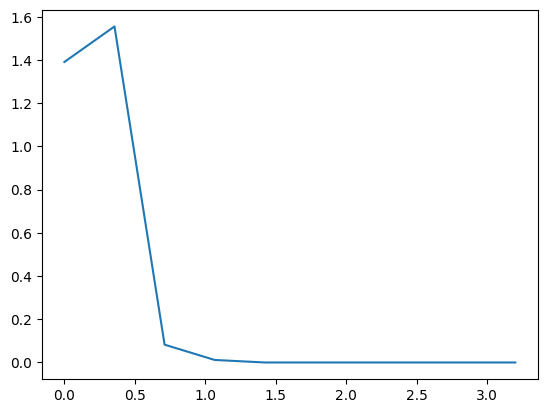

In [20]:
constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
surround_suppresion(ssn_pars, grid_pars, conn_pars, filter_pars, stimulis, post_J, post_s, radii, constant_vector)

55
1.3906534 9.772198e-15
1.554867 30.324553
0.08240353 1.1359785e-18
0.011671582 4.1722275e-16
3.415617e-14 1.3480704e-16
7.483287e-15 1.3251121e-16
5.9251835e-15 1.2580957e-16
5.3272265e-15 1.2537509e-16
5.1275474e-15 1.2563588e-16
5.078595e-15 1.2459394e-16


[DeviceArray(1.3906534, dtype=float32),
 DeviceArray(1.554867, dtype=float32),
 DeviceArray(0.08240353, dtype=float32),
 DeviceArray(0.01167158, dtype=float32),
 DeviceArray(3.415617e-14, dtype=float32),
 DeviceArray(7.483287e-15, dtype=float32),
 DeviceArray(5.9251835e-15, dtype=float32),
 DeviceArray(5.3272265e-15, dtype=float32),
 DeviceArray(5.1275474e-15, dtype=float32),
 DeviceArray(5.078595e-15, dtype=float32)]

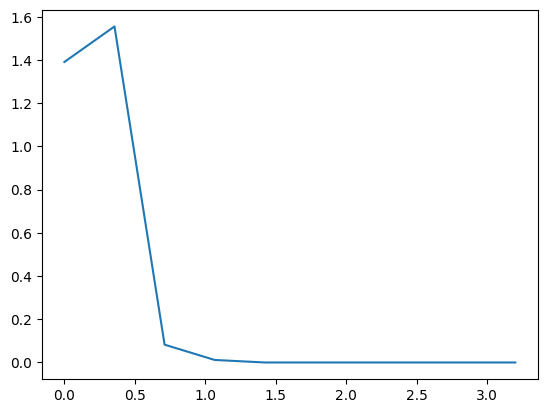

In [21]:
surround_suppresion(ssn_pars, grid_pars, conn_pars, filter_pars, stimulis, pre_J, pre_s, radii, constant_vector)

79.09537


[DeviceArray(9.772198e-15, dtype=float32),
 DeviceArray(30.834986, dtype=float32),
 DeviceArray(6.2638795e-19, dtype=float32),
 DeviceArray(4.175634e-16, dtype=float32),
 DeviceArray(1.1321289e-16, dtype=float32),
 DeviceArray(1.6946793e-16, dtype=float32),
 DeviceArray(1.268216e-16, dtype=float32),
 DeviceArray(1.5749434e-16, dtype=float32),
 DeviceArray(1.598552e-16, dtype=float32),
 DeviceArray(1.4241913e-16, dtype=float32)]

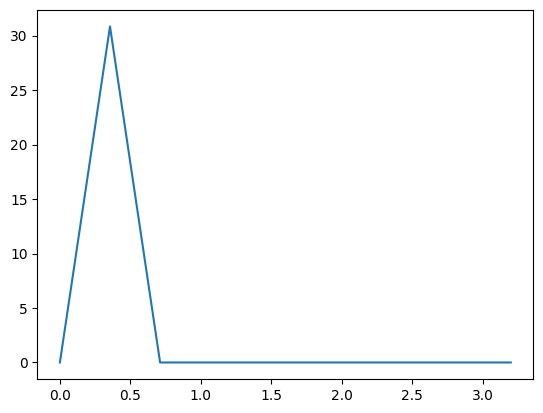

In [21]:
surround_suppresion(ssn_pars, grid_pars, conn_pars, filter_pars, stimulis, pre_J, pre_s, radii, constant_vector)

In [51]:
pre_c

DeviceArray([5., 5.], dtype=float32)

lambda  0.0 , accuracy 0.515
lambda  0.11111111 , accuracy 1.0
lambda  0.22222222 , accuracy 0.62
lambda  0.33333334 , accuracy 1.0
lambda  0.44444445 , accuracy 0.53
lambda  0.5555556 , accuracy 0.515
lambda  0.6666667 , accuracy 0.515
lambda  0.7777778 , accuracy 0.485
lambda  0.8888889 , accuracy 0.485
lambda  1.0 , accuracy 0.515


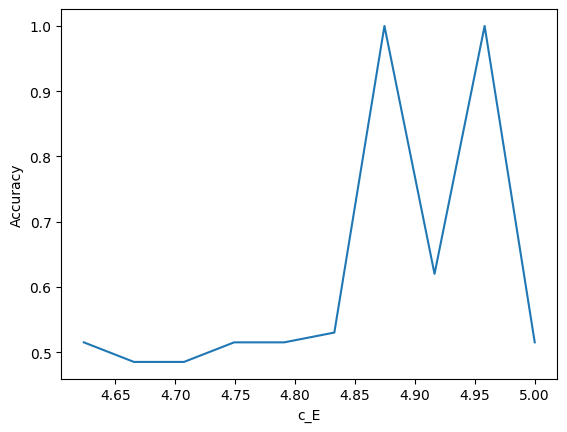

DeviceArray([[0.515    , 5.       , 5.1382585],
             [1.       , 4.9581914, 5.1382585],
             [0.62     , 4.916383 , 5.1382585],
             [1.       , 4.8745737, 5.1382585],
             [0.53     , 4.8327656, 5.1382585],
             [0.515    , 4.7909565, 5.1382585],
             [0.515    , 4.7491474, 5.1382585],
             [0.485    , 4.707339 , 5.1382585],
             [0.485    , 4.66553  , 5.1382585],
             [0.515    , 4.6237216, 5.1382585]], dtype=float32)

In [69]:
case_2(pre_c, post_c, opt_pars, test_data, type_param = 'c', index = (0))

lambda  0.0 , accuracy 0.515
lambda  0.11111111 , accuracy 0.485
lambda  0.22222222 , accuracy 0.93
lambda  0.33333334 , accuracy 0.515
lambda  0.44444445 , accuracy 0.485
lambda  0.5555556 , accuracy 1.0
lambda  0.6666667 , accuracy 0.745
lambda  0.7777778 , accuracy 0.485
lambda  0.8888889 , accuracy 0.655
lambda  1.0 , accuracy 1.0


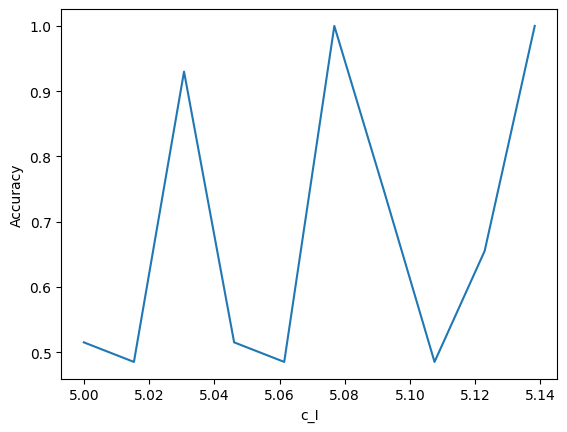

DeviceArray([[0.515    , 4.6237216, 5.       ],
             [0.485    , 4.6237216, 5.0153623],
             [0.93     , 4.6237216, 5.030724 ],
             [0.515    , 4.6237216, 5.046086 ],
             [0.485    , 4.6237216, 5.061448 ],
             [1.       , 4.6237216, 5.0768104],
             [0.745    , 4.6237216, 5.092172 ],
             [0.485    , 4.6237216, 5.1075344],
             [0.655    , 4.6237216, 5.122896 ],
             [1.       , 4.6237216, 5.1382585]], dtype=float32)

In [70]:
case_2(pre_c, post_c, opt_pars, test_data, type_param = 'c', index = (1))

lambda  0.0 , accuracy 1.0
lambda  0.11111111 , accuracy 1.0
lambda  0.22222222 , accuracy 0.55
lambda  0.33333334 , accuracy 0.955
lambda  0.44444445 , accuracy 0.525
lambda  0.5555556 , accuracy 0.475
lambda  0.6666667 , accuracy 0.55
lambda  0.7777778 , accuracy 0.995
lambda  0.8888889 , accuracy 0.525
lambda  1.0 , accuracy 0.58


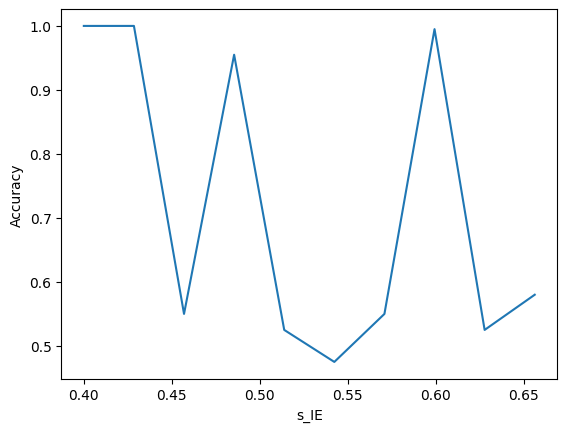

DeviceArray([[1.        , 0.21990065, 0.09      , 0.4       , 0.09      ],
             [1.        , 0.21990065, 0.09      , 0.4284631 , 0.09      ],
             [0.55      , 0.21990065, 0.09      , 0.45692617, 0.09      ],
             [0.955     , 0.21990065, 0.09      , 0.48538923, 0.09      ],
             [0.525     , 0.21990065, 0.09      , 0.51385236, 0.09      ],
             [0.475     , 0.21990065, 0.09      , 0.54231536, 0.09      ],
             [0.55      , 0.21990065, 0.09      , 0.5707785 , 0.09      ],
             [0.995     , 0.21990065, 0.09      , 0.59924155, 0.09      ],
             [0.525     , 0.21990065, 0.09      , 0.6277046 , 0.09      ],
             [0.58      , 0.21990065, 0.09      , 0.6561677 , 0.09      ]],            dtype=float32)

In [45]:
case_2(pre_s, post_s, opt_pars, test_data, type_param = 's', index = (1,0))

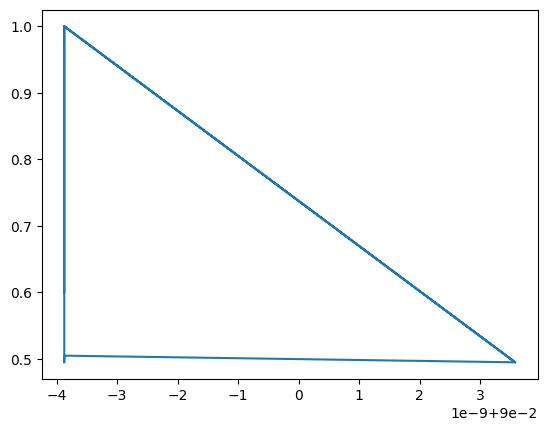

In [33]:
plt.plot(matrix[:, 4].T, matrix[:, 0].T)

In [34]:
matrix[:, 4]

DeviceArray([0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09],            dtype=float32)

In [35]:
matrix[:, 0]

DeviceArray([1.   , 1.   , 0.495, 1.   , 0.495, 0.505, 0.495, 1.   ,
             1.   , 0.6  ], dtype=float32)